## Extract The Data
This first part will extract all the proteins from the articles in the europepmc database which are found by the defined search query

In [0]:
import time
import json
import urllib.request
import csv
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
maxIter = 5
query =  '(sirtuin%20OR%20sirtuins%20OR%20SIRT%20OR%20SIRT1%20OR%20SIRT2%20OR%20SIRT3%20OR%20SIRT4%20OR%20SIRT5%20OR%20SIRT6%20OR%20SIRT7)%20AND%20(Alzheimer%20OR%20alzheimer)'
cursorMark = '*'
pageSize = '1000'

results = []

hitCount = 0

In [0]:
for i in range(0, maxIter):
  url = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=' + query + '&pageSize=' + pageSize + '&resultType=lite&format=JSON&cursorMark=' + cursorMark
  with urllib.request.urlopen(url) as request:
    data = json.loads(request.read().decode())
    cursorMark = data['nextCursorMark']

    if hitCount == 0:
      hitCount = data['hitCount']

    results.append(data['resultList'])

    time.sleep(5)

In [0]:
print(results[0]['result'])

[{'id': '30922179', 'source': 'MED', 'pmid': '30922179', 'pmcid': 'PMC6526831', 'doi': '10.1080/15548627.2019.1596497', 'title': 'Mitophagy and NAD+ inhibit Alzheimer disease.', 'authorString': 'Fang EF.', 'journalTitle': 'Autophagy', 'issue': '6', 'journalVolume': '15', 'pubYear': '2019', 'journalIssn': '1554-8627; 1554-8635; ', 'pageInfo': '1112-1114', 'pubType': 'article-commentary; journal article', 'isOpenAccess': 'Y', 'inEPMC': 'Y', 'inPMC': 'N', 'hasPDF': 'Y', 'hasBook': 'N', 'hasSuppl': 'N', 'citedByCount': 0, 'hasReferences': 'Y', 'hasTextMinedTerms': 'Y', 'hasDbCrossReferences': 'N', 'hasLabsLinks': 'Y', 'hasTMAccessionNumbers': 'N', 'firstIndexDate': '2019-03-30', 'firstPublicationDate': '2019-03-28'}, {'id': '30871086', 'source': 'MED', 'pmid': '30871086', 'pmcid': 'PMC6429449', 'doi': '10.3390/ijms20051249', 'title': "Sirtuins in Alzheimer's Disease: SIRT2-Related GenoPhenotypes and Implications for PharmacoEpiGenetics.", 'authorString': 'Cacabelos R, Carril JC, Cacabelos 

In [0]:
final_results = []

In [0]:
for x in range(0, maxIter):

  print(x)

  for result in results[x]['result']:

    article_id = result['id']
    source = result['source']
    hasTextMinedTerms = result['hasTextMinedTerms']
    pubYear = result['pubYear']

    if hasTextMinedTerms == 'Y':
      if source and article_id:
        url = 'https://www.ebi.ac.uk/europepmc/annotations_api/annotationsByArticleIds?articleIds=' + source + ':' + article_id + '&format=JSON'
        
        with urllib.request.urlopen(url) as request:
          
          data = json.loads(request.read().decode())

          for x in data[0]['annotations']:
            if x['type'] == 'Gene_Proteins':
              name = x['tags'][0]['name']
              uri = x['tags'][0]['uri']

              add = [article_id, pubYear, uri, name]
              final_results.append(add)

0
1
2
3


In [0]:
timestr = time.strftime("%Y%m%d")
filename = "protein_list_" + timestr + ".csv"

In [0]:
# Write the proteins to a csv file
with open(filename, 'w') as out_file:
    csv_out = csv.writer(out_file)
    header = [
        'id; pubyear; uniprot; name']
    csv_out.writerow(header)
    for row in final_results:
        csv_out.writerow(row)

## Load The Already Retrieved Protein List

## Create The Edge List
This part will create an edge list of the retrieved data.

In [0]:
edge = {}
articles = {}
publication_years = {}
edge_articles = {}
symbols = {}

In [0]:
for row in final_results:

  # Index 0 = article id
  # Index 1 = published year
  # Index 2 = Uniprot link to protein
  # Index 3 = Protein name

  # We now create a nested dictionary, the first dictionary key is the article id.
  # The artile id leads to another dictionary containing:
  # Publication year
  # Dictionary of protein name and protein uniprot ID.

  # Get the uniport identifier
  try:
      uniprot_id = row[2].split('/')[-1]
      uniprot_id = uniprot_id.upper()

  except:
      print(f'This: {row} had no uniprot id')

  if uniprot_id:

      year = row[1]
      article_id = row[0]
      protein_name = row[3].upper()

      if uniprot_id not in symbols.keys():
          symbols[uniprot_id] = protein_name

      # Create dictionary of protein name linked to unpirot id

      # Create the dictionary with article ids
      if article_id in articles.keys():
          if uniprot_id not in articles[article_id]['proteins']:
              articles[article_id]['proteins'][uniprot_id] = protein_name
      else:
          articles[article_id] = {
              'year': year,
              'proteins': {
                  uniprot_id: protein_name
              }
          }

  else:
      print(f'This: {row} had no uniprot id')

In [0]:
# Set up some variables to retrieve data about the proteins
amount_to_many = 0
amount_used = 0
total_articles = len(articles.keys())
# Maximum amount of proteins in an article
threshold = 1000

In [0]:
# Loop over the made dictionary add the articles the edge_list
for x in articles:
    if(len(articles[x]['proteins']) <= threshold):
        amount_used += 1

        # Setup two temporary lists with containing the proteins uniprot ids
        temp1 = list(articles[x]['proteins'].keys())
        temp2 = list(articles[x]['proteins'].keys())

        # Loop over the protein uniprot ids of one of the templist
        for y in temp1:

            for z in temp2:

                if y != z:
                    # To circumvent the concern that both interactions are inserted, check for the reverse first
                    # Concern: ('Q9NTG7', 'SIRT3') is for our purposes the same as ('SIRT3', 'Q9NTG7') but python doesnt work that way
                    # Also save the publication year and the articles in a separate dictionary

                    interaction = (y, z)
                    reverse = (z, y)

                    if interaction in edge.keys():
                        edge[interaction] += 1
                        publication_years[interaction].append(
                            int(articles[x]['year']))
                        edge_articles[interaction] += '-' + x
                    elif reverse in edge.keys():
                        edge[reverse] += 1
                        publication_years[reverse].append(
                            int(articles[x]['year']))
                        edge_articles[reverse] += '-' + x
                    else:
                        edge[interaction] = 1
                        publication_years[interaction] = [int(
                            articles[x]['year'])]
                        edge_articles[interaction] = x

            temp2.remove(y)

    else:
        amount_to_many += 1

print(
    f'Treshold of {threshold} results in {amount_used} used and {amount_to_many} not used of {total_articles} articles.')

print(f'First thise were amount of interactions:{len(edge)}')

Treshold of 1000 results in 1284 used and 4 not used of 1288 articles.
First thise were amount of interactions:4119634


In [0]:
# Make a dictionary that keeps only the interactions that occur more than once
# https://stackoverflow.com/questions/18807079/selecting-elements-of-a-python-dictionary-greater-than-a-certain-value/18807120
final = {k: v for (k, v) in edge.items() if v > 3}

test = {k: v for (k, v) in edge.items() if v < 4}
print(f'This amount of interactions occured once and were removed {len(test)}')
print(f'This is the amount of interactions left {len(final)}')

This amount of interactions occured once and were removed 3954192
This is the amount of interactions left 165442


In [0]:
# Calculate the average year for each interaction
average_years = {}
for k, v in publication_years.items():
    average = round(sum(v) / len(v))
    average_years[k] = average

In [0]:
# Make a str of the current day to add to the output file
timestr = time.strftime("%Y%m%d")
filename = "full_gene_edge_list_" + timestr + ".csv"

In [0]:
# Write the edge list to a csv file
with open(filename, 'w') as out_file:
    csv_out = csv.writer(out_file)
    header = [
        'Uniprot ID 1; Gene Symbol 1; Uniprot ID 2; Gene Symbol 2; avg year; artikle_ids']
    csv_out.writerow(header)
    for k in final.keys():
        row = [str(k[0]) + ';' + str(symbols[k[0]]) + ';' + str(k[1]) + ';' + str(symbols[k[1]]) + ';' +
               str(average_years[k]) + ';' + edge_articles[k]]
        csv_out.writerow(row)

## Load The Already Retrieved Edge List

In [0]:
path = '/content/full_gene_edge_list_20200113.csv'
df = pd.read_csv(path, sep=';')

In [4]:
df[' avg year']

0         2017.0
1         2018.0
2         2018.0
3         2016.0
4         2018.0
           ...  
165437    2018.0
165438    2018.0
165439    2016.0
165440    2016.0
165441       NaN
Name:  avg year, Length: 165442, dtype: float64

## Visualize The Data
I want to visualize the data with matplotlib, especially the separation between the years.

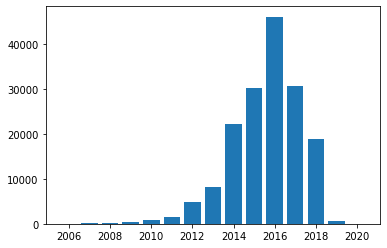

In [27]:
frequency = df[' avg year'].value_counts().to_dict()

labels = frequency.keys()
sizes = frequency.values()

plt.bar(labels, sizes)

plt.show()